#### <p style="text-align: center;">EE 381V: Statistical Machine Learning</p>
# <p style="text-align: center;">Homework 3: Programming Assignments</p>
## <p style="text-align: center;">Total points: 85  </p>
## <p style="text-align: center;">Due: April 5 by 11:59 pm (submission via Gradescope)</p>

Ideally, your solution to the assignments should be written in and submitted as a **Jupyter notebook**. Please make sure your code runs and the graphics (along with anything else that you want to be considered) are displayed in your notebook before submitting.

For the theoretical parts of the questions below (e.g., computation of gradients), the most convenient approach is to type the solution in the provided spaces ("Markdown" cells) using LaTeX (if not familiar with LaTeX, please check the markdown cells below stating questions for examples of writing equations in LaTeX). Alternatively, you could write down the solution on paper and submit a pdf file of the scan/photo.

# <font color='blue'> Problem 1: Random Forest (22 pts) </font>

The goal of this problem is to explore the effect of feature selection using dataset 'loan.csv'.

Select the `loan_status` column as the target column.  


**Part 1: (4 pts)** Split the dataset into train and test set with 25% data in test set and random_state = 42. Perform [Min-Max Scaling](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) on the dataset. Print the total number of features. 

**Part 2: (4 pts)** Use the dataset to create a `RandomForestClassifier(n_estimators=5, random_state=42)` model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to show the precision, recall and F1 score based on the test set.  


**Part 3: (4 pts)** Use $\chi^2$ test to select the top 100, 30 and 10 features using [SelectKBest](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection) module. Train a random forest model and print the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) for each of the trained models.  

**Note:** $\chi^2$ test requires non-negative values only for all features. Since we have performed Min-Max scaling previously (where the default behavior is to scale features between 0 and 1, there should not be any problem performing this test.)   

**Part 4: (5 pts)** [Plot the ROC curves](https://github.com/justmarkham/scikit-learn-tips/blob/master/notebooks/21_plot_roc_curve.ipynb) for all of the 4 models.  

**Part 5: (5 pts)** Plot the feature importance for each of the 4 random forest models that you have trained to show the top 5 features. ([Get feature names after feature selection](https://stackoverflow.com/a/43765224), [Plot feature importance using Pandas and matplotlib](https://stackoverflow.com/a/51520906))

In [31]:
import os, sys, re
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

dataset = pd.read_csv('loan.csv')
df = dataset.fillna(0)

def LoanResult(status):
    if (status == 'Fully Paid') or (status == 'Current'):
        return 1
    else:
        return 0

df['loan_status'] = df['loan_status'].apply(LoanResult)

df = df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
             'emp_length', 'home_ownership','annual_inc', 'verification_status', 'loan_status',
             'purpose','addr_state', 'dti','open_acc', 'pub_rec', 'revol_bal', 'revol_util', 
             'initial_list_status', 'recoveries','collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
             'application_type', 'tot_coll_amt', 'tot_cur_bal', 'avg_cur_bal', 'chargeoff_within_12_mths',
             'pub_rec_bankruptcies', 'tax_liens', 'debt_settlement_flag']]
df_cat = df.select_dtypes(exclude=['int64', 'float64'])
df = pd.get_dummies(df, df_cat.columns.values)
df.head()

/tmp/ipykernel_249133/923416636.py:12: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('loan.csv')


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,loan_status,dti,open_acc,pub_rec,...,last_pymnt_d_Feb-2019,last_pymnt_d_Jan-2019,last_pymnt_d_Jul-2018,last_pymnt_d_Nov-2018,last_pymnt_d_Oct-2018,last_pymnt_d_Sep-2018,application_type_Individual,application_type_Joint App,debt_settlement_flag_N,debt_settlement_flag_Y
0,2500,2500,2500.0,13.56,84.92,55000.0,1,18.24,9.0,1.0,...,True,False,False,False,False,False,True,False,True,False
1,30000,30000,30000.0,18.94,777.23,90000.0,1,26.52,13.0,1.0,...,True,False,False,False,False,False,True,False,True,False
2,5000,5000,5000.0,17.97,180.69,59280.0,1,10.51,8.0,0.0,...,True,False,False,False,False,False,True,False,True,False
3,4000,4000,4000.0,18.94,146.51,92000.0,1,16.74,10.0,0.0,...,True,False,False,False,False,False,True,False,True,False
4,30000,30000,30000.0,16.14,731.78,57250.0,1,26.35,12.0,0.0,...,True,False,False,False,False,False,True,False,True,False


### Your answer:

#### Part 1 (**4 pts**)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['loan_status']), df['loan_status'], test_size=0.25, random_state=42)

# Perform Min-Max Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Print total number of features
print("Total number of features:", X_train_scaled.shape[1])

Total number of features: 160


#### Part 2 (**4 pts**)

In [33]:
rf_model = RandomForestClassifier(n_estimators=5, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test_scaled)

# Print classification report
print("Classification Report for RandomForestClassifier:")
print(classification_report(y_test, y_pred))

Classification Report for RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.63      0.37      0.46       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.81      0.68      0.73     56517
weighted avg       0.98      0.99      0.99     56517



#### Part 3-5: **14 pts**


/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Classification Report for RandomForestClassifier with 100 features:
              precision    recall  f1-score   support

           0       0.67      0.42      0.51       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.83      0.71      0.75     56517
weighted avg       0.99      0.99      0.99     56517



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Classification Report for RandomForestClassifier with 30 features:
              precision    recall  f1-score   support

           0       0.33      0.24      0.28       850
           1       0.99      0.99      0.99     55667

    accuracy                           0.98     56517
   macro avg       0.66      0.62      0.63     56517
weighted avg       0.98      0.98      0.98     56517



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Classification Report for RandomForestClassifier with 10 features:
              precision    recall  f1-score   support

           0       0.80      0.09      0.16       850
           1       0.99      1.00      0.99     55667

    accuracy                           0.99     56517
   macro avg       0.89      0.54      0.57     56517
weighted avg       0.98      0.99      0.98     56517



/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/

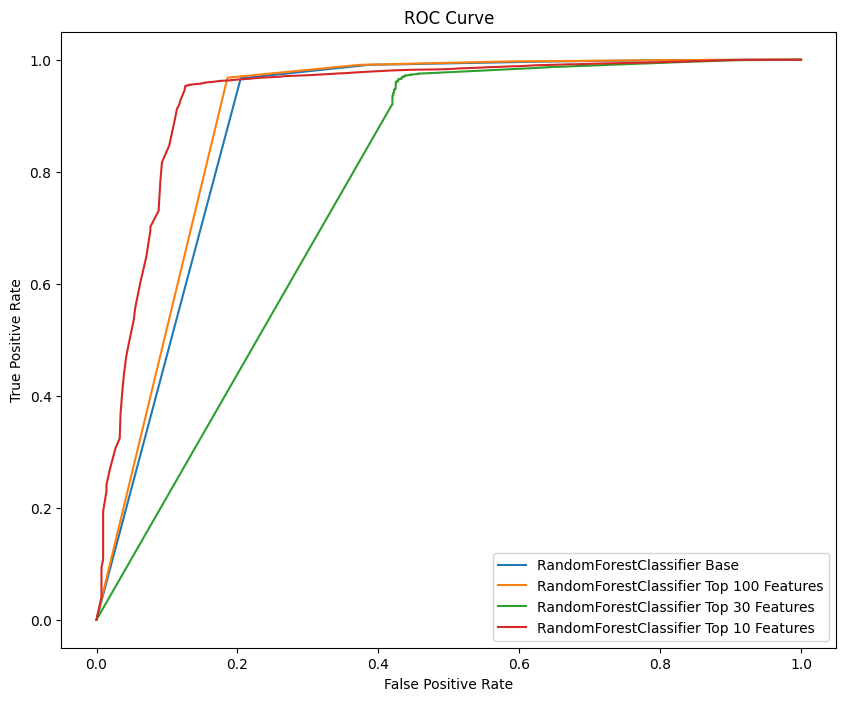

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [19] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/

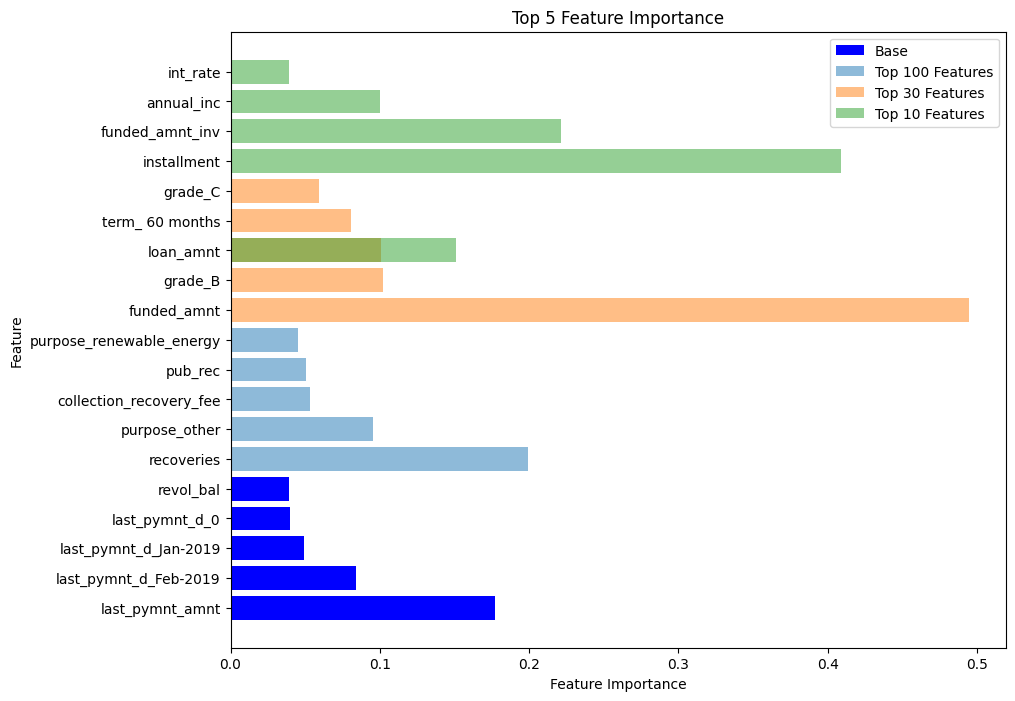

In [35]:
def train_and_report(num_features):
    selector = SelectKBest(f_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    rf_model_selected = RandomForestClassifier(n_estimators=5, random_state=42)
    rf_model_selected.fit(X_train_selected, y_train)
    y_pred_selected = rf_model_selected.predict(X_test_selected)
    
    print(f"Classification Report for RandomForestClassifier with {num_features} features:")
    print(classification_report(y_test, y_pred_selected))

# Train models with top 100, 30, and 10 features
for num_features in [100, 30, 10]:
    train_and_report(num_features)

# Part 4
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

# Base RandomForestClassifier
y_pred_proba_base = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr_base, tpr_base, _ = roc_curve(y_test, y_pred_proba_base)
plt.plot(fpr_base, tpr_base, label='RandomForestClassifier Base')

# Models with top 100, 30, and 10 features
for num_features in [100, 30, 10]:
    # Remove constant features
    constant_features = X_train_scaled.var(axis=0) == 0
    X_train_filtered = X_train_scaled[:, ~constant_features]
    X_test_filtered = X_test_scaled[:, ~constant_features]
    
    selector = SelectKBest(f_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    rf_model_selected = RandomForestClassifier(n_estimators=5, random_state=42)
    rf_model_selected.fit(X_train_selected, y_train)
    
    y_pred_proba_selected = rf_model_selected.predict_proba(X_test_selected)[:, 1]
    fpr_selected, tpr_selected, _ = roc_curve(y_test, y_pred_proba_selected)
    plt.plot(fpr_selected, tpr_selected, label=f'RandomForestClassifier Top {num_features} Features')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Part 5
# Plot feature importance for all models
plt.figure(figsize=(10, 8))

# Base RandomForestClassifier
feature_importance_base = rf_model.feature_importances_
sorted_indices_base = np.argsort(feature_importance_base)[::-1]
top_features_base = X_train.columns[sorted_indices_base][:5]
plt.barh(top_features_base, feature_importance_base[sorted_indices_base][:5], color='b', label='Base')

# Models with top 100, 30, and 10 features
for num_features in [100, 30, 10]:
    selector = SelectKBest(f_classif, k=num_features)
    X_train_selected = selector.fit_transform(X_train_scaled, y_train)
    X_test_selected = selector.transform(X_test_scaled)
    
    rf_model_selected = RandomForestClassifier(n_estimators=5, random_state=42)
    rf_model_selected.fit(X_train_selected, y_train)
    
    feature_importance_selected = rf_model_selected.feature_importances_
    sorted_indices_selected = np.argsort(feature_importance_selected)[::-1]
    top_features_selected = X_train.columns[sorted_indices_selected][:5]
    plt.barh(top_features_selected, feature_importance_selected[sorted_indices_selected][:5], alpha=0.5, label=f'Top {num_features} Features')

plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 5 Feature Importance')
plt.legend()
plt.show()

# <font color='blue'> Problem 2:  Boosting (26 pts) </font>
In this problem, you are asked to implement AdaBoost with decision stumps (basically, depth-1 decision trees) and apply it to classify data in 'spamdata.mat'. Select the number of boosting rounds $T^{*}$ from $\mathcal{T}=\{100,200, \ldots, 1000\}$; how did you choose this parameter? Plot the errors on the training and test sets as functions of the number of rounds of boosting $t \in\left[1, T^{*}\right]$.
[Note: If you want to write the code from scratch yourself, you do not have to follow the suggested code structure given below.]

**Part 1: Decision Stump (10 pts)** 
Adaboost is one of the oldest boosting algorithm, capable of converting an ensemble of weak classifiers into a strong classifier. We will use [Decision Stumps](https://en.wikipedia.org/wiki/Decision_stump) as our base (weak) classifiers.

**Part 2: Adaboost (10 pts)** 
This is the same algorithm as we learned in class. You create a new weak learner based on the current sample weights, compute the error of the created weak learner, compute the new learner's weight using the formula $w_{t}=\frac{1}{2} \log \left(\frac{1}{\epsilon_{t}}-1\right)$, and finally update the sample weights. In the next iteration, identify a new weak learner based on the updated sample weights.

**Part 3: Boosting (6 pts)**
Use your Decision Stumps and Adaboost algorithms to run boosting.

### Your answer:

#### Part 1: Decision Stump (10 pts)

In [67]:
import numpy as np
from operator import lt,ge

class DecisionStump:
    """
    A simple decision stump classifier
    dim : dimension on which to split
    value : value of the dimension
    op : comparator function (either <, <, >= or <=)
    """
    def __init__(self, dim=0, value=0, op=lt):
        self.dim = dim
        self.value = value
        self.op = op
        
    def update(self, dim=None, value=None, op=None):
        if dim is not None: self.dim = dim
        if value is not None: self.value = value
        if op is not None: self.op = op
    
    def predict(self,X):
        return np.array([1 if self.op(x, self.value) else -1 for x in X[:,self.dim]])         

    def fit_dim(self,X,Y,sample_weights,num_splits):
        min_err = float('inf')
        split_value = None
        op = None

        for dim in range(X.shape[1]):
            sorted_indices = X[:, dim].argsort()
            thresholds = np.unique(X[sorted_indices, dim])  # Unique sorted thresholds
            for threshold in np.random.choice(thresholds, size=num_splits, replace=False):
                for operator in [lt, ge]:
                    error = np.sum((self.predict(X[:, dim].reshape(-1, 1)) != Y) * sample_weights)
                    if error < min_err:
                        min_err = error
                        split_value = threshold
                        op = operator

        return min_err, split_value, op
    
    def fit_data(self,X,Y,sample_weights,num_splits=2):
        min_err, split_value, op = self.fit_dim(X, Y, sample_weights, num_splits)
        self.update(value=split_value, op=op)

#### Part 2: Adaboost (10 pts)

In [68]:
class Adaboost:
    def __init__(self, n, weak_learners=None, learner_weights=None):
        self.weak_learners = weak_learners if weak_learners is not None else []
        self.learner_weights = learner_weights if learner_weights is not None else []
        self.sample_weights = np.repeat(1/n,n)
                  
    def add_learner(self, X, Y, weak_learner_class = DecisionStump):
        weak_learner = weak_learner_class()
        weak_learner.fit_data(X, Y, self.sample_weights)
        predictions = weak_learner.predict(X)
        error = np.sum(predictions != Y) / len(Y)
        alpha = 0.5 * np.log((1 - error) / error)
        self.weak_learners.append(weak_learner)
        self.learner_weights.append(alpha)
        self.sample_weights *= np.exp(-alpha * Y * predictions)
        self.sample_weights /= np.sum(self.sample_weights)  # Normalize weights

    def predict(self,X):
        predictions = np.zeros(X.shape[0])
        for learner, weight in zip(self.weak_learners, self.learner_weights):
            predictions += weight * learner.predict(X)
        return np.sign(predictions)

    def prediction_error(self,X,Y):
        predictions = self.predict(X)
        return np.sum(predictions != Y) / len(Y)



#### Part 3: Boosting (6 pts)


In [69]:
import random
import matplotlib.pyplot as plt
import scipy.io


def plot_results(train_error, test_error):
    """
    Plot error on the training and test set as a function 
    of the number of rounds of boosting.
    """
    plt.plot(train_errors, label='Train Error')
    plt.plot(test_errors, label='Test Error')
    plt.xlabel('Number of Rounds')
    plt.ylabel('Error')
    plt.title('Adaboost Errors')
    plt.legend()
    plt.show()

Training Adaboost with weak learners 1
Training Adaboost with weak learners 2
Training Adaboost with weak learners 3
Training Adaboost with weak learners 4
Training Adaboost with weak learners 5
Training Adaboost with weak learners 6
Training Adaboost with weak learners 7
Training Adaboost with weak learners 8
Training Adaboost with weak learners 9
Training Adaboost with weak learners 10
Training Adaboost with weak learners 11
Training Adaboost with weak learners 12
Training Adaboost with weak learners 13
Training Adaboost with weak learners 14
Training Adaboost with weak learners 15
Training Adaboost with weak learners 16
Training Adaboost with weak learners 17
Training Adaboost with weak learners 18
Training Adaboost with weak learners 19
Training Adaboost with weak learners 20
Training Adaboost with weak learners 21
Training Adaboost with weak learners 22
Training Adaboost with weak learners 23
Training Adaboost with weak learners 24
Training Adaboost with weak learners 25
Training 

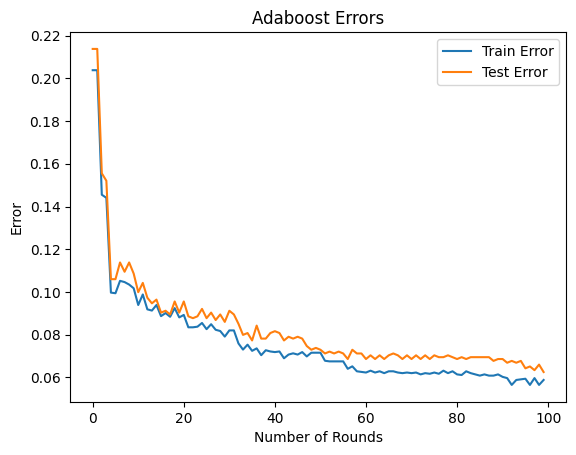

In [70]:
from sklearn.model_selection import train_test_split
#Read in the dataset
dataFile = 'spamdata.mat'
data = scipy.io.loadmat(dataFile)['spamdata']
X = data[:,0:57]
y = data[:,57]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=50)

# normalize data
X_train = np.log(X_train + 0.1 * np.ones((len(X_train), len(X_train[0]))))
X_test = np.log(X_test + 0.1 * np.ones((len(X_test), len(X_test[0]))))
y_train = 2 * y_train - 1
y_test = 2 * y_test - 1

#Maximum number of weak learners to be used in Adaboost
max_num_weak_learners = 100

#Train and test error
train_error = []
test_error = []

#Training Adaboost with weak learners
n,d = X_train.shape
model = Adaboost(n)
for m in range(1, max_num_weak_learners + 1):
    print("Training Adaboost with weak learners %d" % m)
    model.add_learner(X_train, y_train)
    train_error.append(model.prediction_error(X_train, y_train))
    test_error.append(model.prediction_error(X_test, y_test))

print("Initial Training Error=%.4f Testing Error= %.4f " % (train_error[0], test_error[0]))
print("Final Training Error=%.4f Testing Error= %.4f " % (train_error[-1], test_error[-1]))
plot_results(train_error, test_error)

In [42]:
import numpy as np
from operator import lt, ge

class DecisionStump:
    """
    A simple decision stump classifier
    dim : dimension on which to split
    value : value of the dimension
    op : comparator function (either <, >, <=, or >=)
    """
    def __init__(self, dim=0, value=0, op=lt):
        self.dim = dim
        self.value = value
        self.op = op
        
    def update(self, dim=None, value=None, op=None):
        if dim is not None: self.dim = dim
        if value is not None: self.value = value
        if op is not None: self.op = op
    
    def predict(self, X):
        return np.array([1 if self.op(x, self.value) else -1 for x in X[:, self.dim]])         
    
    def fit_dim(self, X, Y, sample_weights, num_splits):
        min_err = float('inf')
        split_value = None
        optimal_op = None

        # Iterate through dimensions
        for dim in range(X.shape[1]):
            # Find optimal split for the current dimension
            err, value, op = self.find_optimal_split(X[:, dim], Y, sample_weights, num_splits)
            if err < min_err:
                min_err = err
                split_value = value
                optimal_op = op
                self.dim = dim
        
        return min_err, split_value, optimal_op
    
    def find_optimal_split(self, feature, Y, sample_weights, num_splits):
        min_err = float('inf')
        split_value = None
        optimal_op = None

        # Randomly select split values
        split_values = np.random.choice(np.unique(feature), size=num_splits, replace=False)
        
        for value in split_values:
            for op in [lt, ge]:  # Try both < and >=
                predictions = np.array([1 if op(x, value) else -1 for x in feature])
                err = np.sum(sample_weights * (predictions != Y))

                if err < min_err:
                    min_err = err
                    split_value = value
                    optimal_op = op
        
        return min_err, split_value, optimal_op
    
    def fit_data(self, X, Y, sample_weights, num_splits=100):
        min_err, split_value, op = self.fit_dim(X, Y, sample_weights, num_splits)
        self.update(value=split_value, op=op)


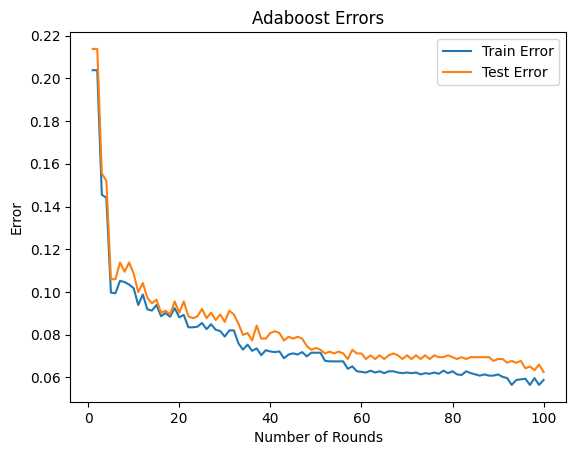

In [71]:
import numpy as np
import scipy.io
from sklearn.tree import DecisionTreeClassifier

# Part 1: Decision Stump
def train_decision_stump(X, y, weights):
    stump = DecisionTreeClassifier(max_depth=1)
    stump.fit(X, y, sample_weight=weights)
    return stump

# Part 2: Adaboost
def adaboost(X_train, y_train, X_test, y_test, num_rounds):
    n_train = len(X_train)
    n_test = len(X_test)
    weights = np.ones(n_train) / n_train
    alphas = []
    stumps = []
    train_errors = []
    test_errors = []

    for t in range(num_rounds):
        # Train weak learner
        stump = train_decision_stump(X_train, y_train, weights)

        #stump = DecisionStump()
        #stump.fit_dim(X_train, y_train, weights, num_splits=2)
        # Calculate error
        train_pred = stump.predict(X_train)
        test_pred = stump.predict(X_test)
        err = np.sum(weights * (train_pred != y_train))
        alpha = 0.5 * np.log((1 - err) / max(err, 1e-10))  # Avoid division by zero
        weights *= np.exp(-alpha * y_train * train_pred)
        weights /= np.sum(weights)
        
        # Save results
        alphas.append(alpha)
        stumps.append(stump)
        
        # Calculate train and test errors
        train_errors.append(1 - np.mean(np.sign(np.sum([alpha * stump.predict(X_train) for alpha, stump in zip(alphas, stumps)], axis=0)) == y_train))
        test_errors.append(1 - np.mean(np.sign(np.sum([alpha * stump.predict(X_test) for alpha, stump in zip(alphas, stumps)], axis=0)) == y_test))
    
    return train_errors, test_errors

# Part 3: Boosting
# Read in the dataset
dataFile = 'spamdata.mat'
data = scipy.io.loadmat(dataFile)['spamdata']
X = data[:, 0:57]
y = data[:, 57]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

# Normalize data
X_train = np.log(X_train + 0.1 * np.ones((len(X_train), len(X_train[0]))))
X_test = np.log(X_test + 0.1 * np.ones((len(X_test), len(X_test[0]))))
y_train = 2 * y_train - 1
y_test = 2 * y_test - 1

# Maximum number of weak learners to be used in Adaboost
max_num_weak_learners = 100

# Train and test error
train_error = []
test_error = []
train_errors, test_errors = adaboost(X_train, y_train, X_test, y_test, num_rounds)

# Plot errors
import matplotlib.pyplot as plt

rounds = range(1, max_num_weak_learners + 1)
plt.plot(rounds, train_errors, label='Train Error')
plt.plot(rounds, test_errors, label='Test Error')
plt.xlabel('Number of Rounds')
plt.ylabel('Error')
plt.title('Adaboost Errors')
plt.legend()
plt.show()

# <font color='blue'> Problem 3: Comparing different classification ensembles method (22 pts) </font>

In this problem, we will compare performance of different ensemble methods for classification: [Bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html), [AdaBoost](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html), [GradientBoosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), and [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifiers.

[Spam Classification Data](https://archive.ics.uci.edu/ml/datasets/Spambase) of UCI will be used ('spamdata.mat', exactly the same dataset we used in Problem 2).

* Load the data and partition it into features (X) and the target label (y) for classification task. Then, use [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split data into training and testing: test_size=0.33, random_state=42. 



**Part 1: (5 pts)** Use a Decision Tree Classifier with random_state = 10 and Logistic Regression with random_state = 10 and solver ="lbfgs" for the spam classification problem. Report the accuracy_score and roc_auc_score on the test data for each classifier.


**Part 2: (5 pts)** Create an ensemble of 50 classifiers (i.e., n_estimators = 50) with random_state = 10 for [bagging](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) with base classifiers being Decision Tree Classifier and Logistic Regression from part $1$ . Report accuracy_score and roc_auc_score on the test data for both Bagging classifiers. Compare the results and briefly explain the effect of using bagging for the spam classification problem for both the Logistic Regression and Decision Tree base classifiers.

**Part 3: (5 pts)** Use a [Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to classify whether an email is spam. Report your testing accuracy ([accuracy_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)) and [roc_auc_score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score). You will need [predict_proba](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) for roc_auc_score. 


**Part 4: (5 pts)** Use [Gradient Boosting Decision Tree](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) (GBDT), and [AdaBoost](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier) for the spam classification problem.  Report  accuracy_score and roc_auc_score on the test data for each algorithm. 

  Note : For part 3 and 4 find the best values for the hyper parameters of each of the models by using GridSearchCV. 


**Part 5: (2 pts)** Briefly explain which of the three ensemble method above from Part 3 & 4 performed the best and why?

### Your answer:

#### Loading and pre-processing dataset

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)


dataFile = 'spamdata.mat'
data = scipy.io.loadmat(dataFile)['spamdata']
print(data)
x_total = data[:,0:57]
print(x_total)
y_total = data[:,57]
print(y_total)
x_train, x_test, y_train, y_test = train_test_split(x_total, y_total, test_size=0.33, random_state=42)

[[6.00e-02 0.00e+00 2.40e-01 ... 2.60e+01 2.51e+03 1.00e+00]
 [0.00e+00 0.00e+00 2.00e-01 ... 5.50e+01 4.90e+02 1.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 ... 7.00e+00 4.80e+01 1.00e+00]
 ...
 [0.00e+00 0.00e+00 0.00e+00 ... 1.10e+01 4.30e+01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 ... 1.00e+00 3.50e+01 0.00e+00]
 [9.50e-01 0.00e+00 0.00e+00 ... 1.50e+01 4.90e+01 0.00e+00]]
[[6.000e-02 0.000e+00 2.400e-01 ... 2.813e+00 2.600e+01 2.510e+03]
 [0.000e+00 0.000e+00 2.000e-01 ... 7.538e+00 5.500e+01 4.900e+02]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.333e+00 7.000e+00 4.800e+01]
 ...
 [0.000e+00 0.000e+00 0.000e+00 ... 1.720e+00 1.100e+01 4.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 ... 1.000e+00 1.000e+00 3.500e+01]
 [9.500e-01 0.000e+00 0.000e+00 ... 2.130e+00 1.500e+01 4.900e+01]]
[1. 1. 1. ... 0. 0. 0.]


#### Part 1 (**5 pts**)

#### Part 2 (**5 pts**)

#### Part 3 (**5 pts**)

#### Part 4 (**5 pts**)

#### Part 5 (**2 pts**)

# <font color='blue'> Problem 4: Support Vector Machines (15 pts) </font>
Let us revisit the task of classifying e-mails as spam vs. not spam. To solve this problem, we will use the SVM with a polynomial kernel. You are allowed to use any existing [libraries](https://scikit-learn.org/stable/modules/svm.html). You can find the dataset file 'spamdata.mat' in Canvas, just below this assignment. Use the first 3000 examples for training, the last 1600 for testing. Start by randomly splitting the training data into ten equal-sized disjoint sets. For each value of the polynomial degree d = {1, 2, 3, 4}, plot the average cross-validation error as a function of the cost (regularization) parameter C. Vary C from a small value C = $2^{-k}$ to C = $2^{k}$, choosing k so that you see a significant variation in training error (from a very high training error to a low training error). Let ($C^{*}, d^{*}$) be the best pair of parameters you identified; from that point on, fix $C = C^{*}$. Plot the ten-fold cross-validation error and the test errors for the hypotheses obtained as a function of d.

**Part 1: (3 pts)** Load data 'spamdata.mat' with [scipy.io.loadmat](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.loadmat.html) and print out the shape of X and y.

**Part 2: cross validation (8 pts)**
Train the SVM with different kernel degrees and regularization constants. Save the results corresponding to different parameters.

**Part 3: plotting results (4 pts)**
Plot the results corresponding to different parameters and choose the best hyperparameters.

In [5]:
import scipy.io
import numpy as np
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Your answer:

#### Part 1 (**3 pts**)

In [2]:
# Load data
data = scipy.io.loadmat('spamdata.mat')
spamdata = data['spamdata']

# Extract features and labels
X = spamdata[:,0:57]
y = spamdata[:,57]

# Print the shapes of X and y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (4601, 57)
Shape of y: (4601,)


#### Part 2 (**8 pts**)

In [3]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[:3000], y[:3000], test_size=1600, random_state=42)

# Define range for C and polynomial degrees
C_range = [2**i for i in range(-5, 6)]  # Varying C from 2^-5 to 2^5
degree_range = [1, 2, 3, 4]

# Dictionary to store cross-validation results
cv_results = {}

# Loop over each polynomial degree
for degree in degree_range:
    print(f"Degree range: {degree}")
    cv_results[degree] = []
    # Loop over each value of C
    for C_val in C_range:
        # Train SVM
        svm = SVC(kernel='poly', degree=degree, C=C_val)
        # Perform cross-validation
        scores = cross_val_score(svm, X_train, y_train.ravel(), cv=10, scoring='accuracy')
        # Calculate average cross-validation error
        avg_cv_error = 1 - np.mean(scores)
        cv_results[degree].append(avg_cv_error)

# Print the results
for degree in degree_range:
    print(f"Results for degree {degree}:")
    for i, C_val in enumerate(C_range):
        print(f"C = {C_val}, Avg. CV Error = {cv_results[degree][i]}")
    print()


Degree range: 1
average cv error: 0.3371428571428571
average cv error: 0.3314285714285713
average cv error: 0.3292857142857142
average cv error: 0.3292857142857142
average cv error: 0.3264285714285713
average cv error: 0.3214285714285714
average cv error: 0.3085714285714285
average cv error: 0.29928571428571427
average cv error: 0.2978571428571428
average cv error: 0.29000000000000004
average cv error: 0.27928571428571425
Degree range: 2
average cv error: 0.35285714285714276
average cv error: 0.3514285714285714
average cv error: 0.3471428571428572
average cv error: 0.34071428571428564
average cv error: 0.3335714285714284
average cv error: 0.3321428571428571
average cv error: 0.32785714285714274
average cv error: 0.3264285714285713
average cv error: 0.32785714285714274
average cv error: 0.32714285714285707
average cv error: 0.3264285714285713
Degree range: 3
average cv error: 0.3514285714285714
average cv error: 0.3514285714285714
average cv error: 0.34857142857142853
average cv error: 

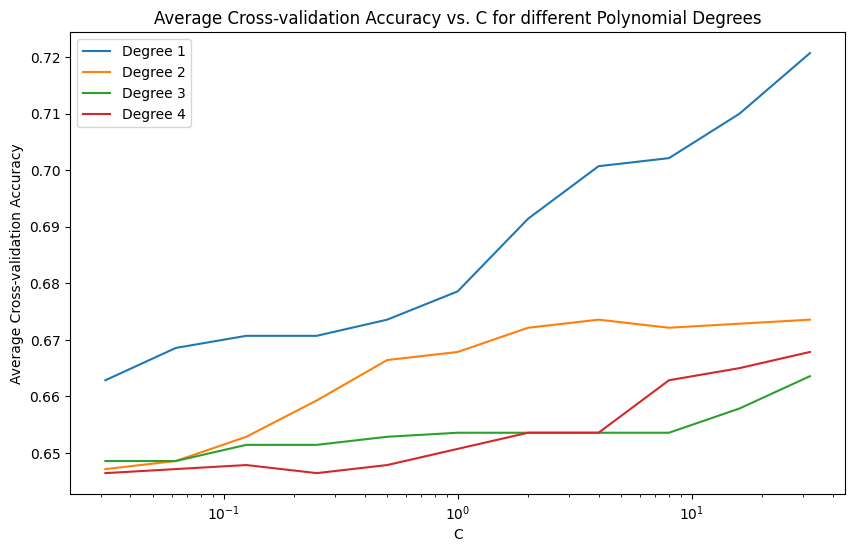

Best parameters: {'C': 32, 'degree': 1}


In [6]:
## Optimized Version

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X[:3000], y[:3000], test_size=1600, random_state=42)

# Define range for C and polynomial degrees
param_grid = {'C': [2**i for i in range(-5, 6)], 'degree': [1, 2, 3, 4]}

# Perform grid search with cross-validation
svm_grid = GridSearchCV(SVC(kernel='poly'), param_grid, cv=10, scoring='accuracy')
svm_grid.fit(X_train, y_train.ravel())

# Extract best parameters and results
best_params = svm_grid.best_params_
cv_results = svm_grid.cv_results_

# Plotting results
plt.figure(figsize=(10, 6))
for degree in param_grid['degree']:
    mask = cv_results['param_degree'] == degree
    plt.plot(param_grid['C'], cv_results['mean_test_score'][mask], label=f'Degree {degree}')

plt.xlabel('C')
plt.ylabel('Average Cross-validation Accuracy')
plt.title('Average Cross-validation Accuracy vs. C for different Polynomial Degrees')
plt.xscale('log')
plt.legend()
plt.show()

print("Best parameters:", best_params)


#### Part 3 (**4 pts**)

In [ ]:
# Plotting cross-validation error as a function of C for different polynomial degrees
for degree in degree_range:
    plt.plot(C_range, cv_results[degree], label=f'Degree {degree}')

plt.xlabel('C')
plt.ylabel('Average Cross-validation Error')
plt.title('Average Cross-validation Error vs. C for different Polynomial Degrees')
plt.legend()
plt.xscale('log')
plt.show()
